In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch.autograd import Variable
from tqdm import tqdm

import cmapy
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER, SAVEFOLDER

In [2]:
src_domain = 'Thebe'
tgt_domain = 'Thebe'
da_method = 'DANN'

# test
smooth = True

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
# training run

# run_id = "rposfbdr"
# net = "unet2d"
# branch = "conv_3"

run_id = "0ivmnow8"
net = "dexined"
branch = "blk4" 

# run_id = "40hguylp"
# net = "at-unet"
# branch = "conv3"

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATAPATH = os.path.join(DATAFOLDER, tgt_domain)

In [5]:
filepath_weigths = os.path.join(SAVEFOLDER, '{}.pt'.format(run_id))

f = 16

ps = 256
stride = ps//2

In [6]:
UPPER_BOUND = 800
LOWER_BOUND = 1300

In [7]:
from dataloaders import PatchGenerator, ResizeGeneratorTest
from torch.utils.data import DataLoader

h, w = 1537, 3174

patch_generator = PatchGenerator((h,w), ps, stride)

nx, left_pad, right_pad, ny, top_pad, bottom_pad
26 141 141 14 191 192


## Load Model

In [8]:
from models.unet_dann import UNet2D
from models.dexined_dann import DexiNed
from models.at_unet_dann import AtrousUNet

In [9]:
if net == "unet2d":
    model = UNet2D(f1=f, branches=branch.split(',')).to(device)
elif net == "at-unet": 
    model = AtrousUNet(f1=f, depth=4, branches=branch.split(',')).to(device)
elif net == "dexined": 
    model = DexiNed(f1=f, branches=branch.split(',')).to(device)
else:
    print("Error")

model.load_state_dict(torch.load(filepath_weigths))
model.eval()
print()

## Create inferences from generated patches 

In [10]:
from utils import *

In [11]:
def computeResultsnResize(test_loader, smooth=False):     

    test_predictions = []
    for images in test_loader:

        y_preds = model(images.float().to(device), alpha=0)[0]

        if net == "dexined":
            y_preds = (y_preds[-1] + y_preds[2] + y_preds[3])/3.
            y_preds = torch.nn.Sigmoid()(y_preds)
            
        y_preds = y_preds.detach().cpu().numpy()
        
        x_list = []
        for x in y_preds:
            x = cv2.resize(x[0], (ps,ps))
            x = np.expand_dims(x, axis=0)
            x_list.append(x)
        
        y_preds = np.vstack(x_list)
        y_preds = np.expand_dims(y_preds, axis=1)
        
        test_predictions.extend(y_preds)
        
    test_predictions = np.vstack(test_predictions)
    test_predictions = np.expand_dims(test_predictions, axis=1)
    test_predictions = np.moveaxis(test_predictions,-3,-1)
    
    if smooth:
        WINDOW_SPLINE_2D = window_2D(window_size=ps, power=2)
        test_predictions = np.array([patch * WINDOW_SPLINE_2D for patch in test_predictions])
    
    test_predictions = test_predictions.reshape((patch_generator.ny, patch_generator.nx, ps, ps, 1))
    
    Y_pred = patch_generator.reconstruct_image(test_predictions)
    
    return np.squeeze(Y_pred)

In [12]:
list_files = os.listdir('{}/test/seismic/'.format(DATAPATH))
print("Number of crosslines for test: ", len(list_files))

# make sure that the last one is the same one that is evaluated in the paper
list_files.remove('20.npy')
list_files.append('20.npy')

list_files[-5:]

Number of crosslines for test:  141


['96.npy', '97.npy', '98.npy', '99.npy', '20.npy']

In [13]:
y_true_list = []
y_prob_list = []
for xline in tqdm(list_files):
    
    # load crossline 
    seis = np.load('{}/test/seismic/{}'.format(DATAPATH, xline))

    # scaling
    mean_ = seis.mean()
    std_ = seis.std()
    seis = (seis - mean_)/std_

    # generate patches of 256
    X = patch_generator.get_patches(seis)
    
    # load patches to data generator
    test_gen = ResizeGeneratorTest(X) # 256 -> 128
    test_loader = DataLoader(dataset=test_gen, batch_size=256, shuffle=False)

    # reconstruct crossline
    fault_probs = computeResultsnResize(test_loader, smooth=smooth)[UPPER_BOUND:LOWER_BOUND,:] # 128 -> 256
    fault_probs = np.expand_dims(fault_probs, 0)
    
    # real
    fault_test = np.load('{}/test/annotation/{}'.format(DATAPATH, xline))[UPPER_BOUND:LOWER_BOUND,:]
    fault_test = np.expand_dims(fault_test, 0)
    
    y_true_list.append(fault_test)
    y_prob_list.append(fault_probs)
    
y_true_total = np.vstack(y_true_list)  #.ravel()
y_prob_total = np.vstack(y_prob_list) #.ravel()
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)

y_true_total.shape

100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [01:44<00:00,  1.34it/s]


(141, 500, 3174)

## Visual Evaluation

(-0.5, 3173.5, 499.5, -0.5)

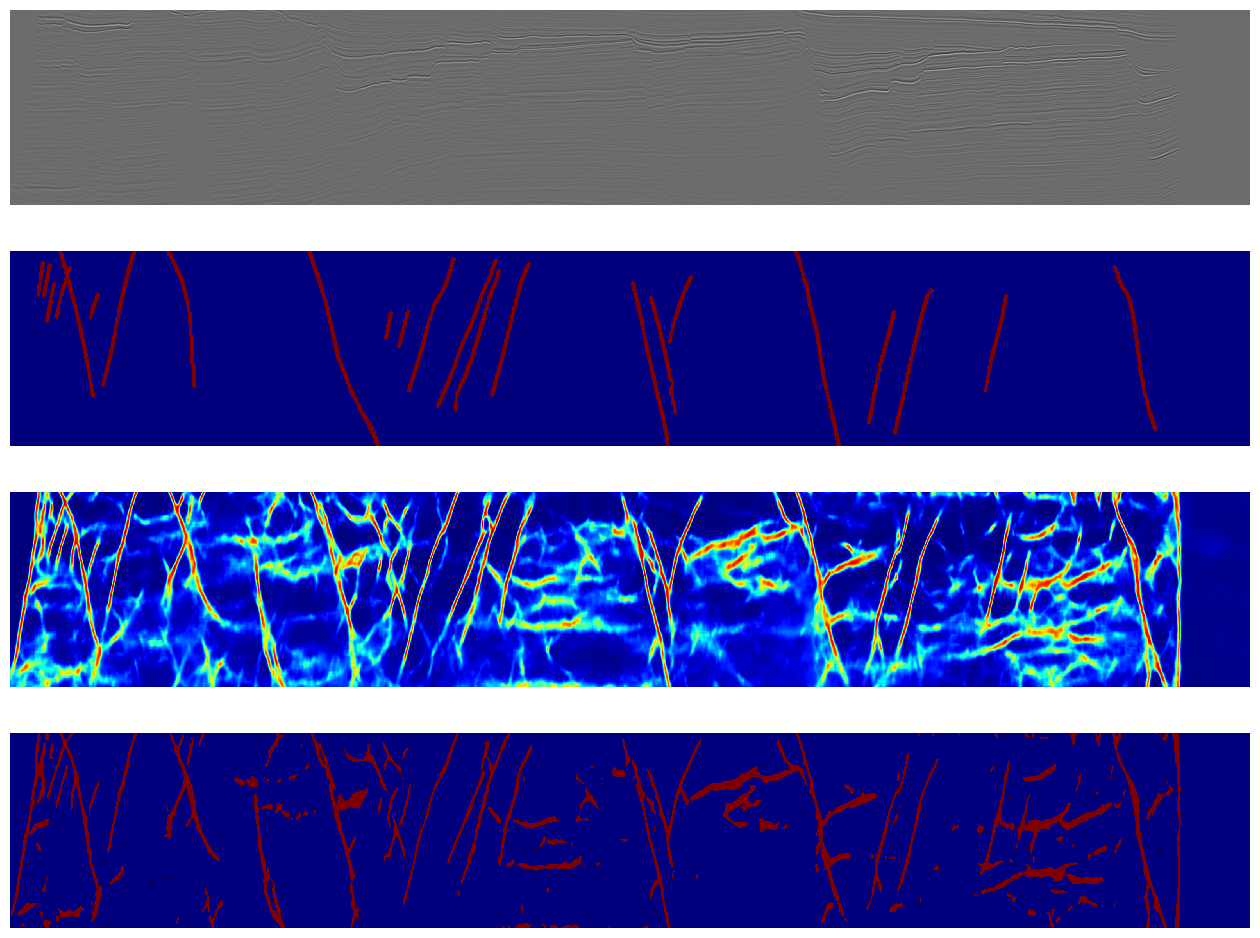

In [14]:
heatmap_img = cv2.applyColorMap((y_prob_total[-1]*255).astype(np.uint8), cmapy.cmap('jet_r'))

fig, axes = plt.subplots(4, 1, figsize=[16,12])

axes[0].imshow(seis[UPPER_BOUND:LOWER_BOUND,:], cmap="gray")
axes[0].axis('off')
axes[1].imshow(y_true_total[-1], cmap='jet', interpolation='nearest')
axes[1].axis('off')
axes[2].imshow(heatmap_img, cmap='jet', interpolation='nearest')
axes[2].axis('off')
axes[3].imshow(y_pred_total[-1], cmap='jet', interpolation='nearest')
axes[3].axis('off')

## Evaluation

In [15]:
# from torchmetrics import AveragePrecision, AUROC
from metrics import *

In [16]:
th_range = np.arange(0, 1, 0.02)
metrics_list = []

y_true = torch.tensor(y_true_total, dtype=torch.float32).to(device)
y_prob = torch.tensor(y_prob_total, dtype=torch.float32).to(device)

for th in th_range:
    pr, re, f1 = binary_classification_metrics(y_prob, y_true, th)
    metrics_list.append([pr, re, f1])

In [17]:
df = pd.DataFrame(np.array(metrics_list)).reset_index(drop=True)
df.columns = ['precision', 'recall', 'f1_score']
df.index = th_range

In [18]:
f1_ = df.loc[0.5]['f1_score']
# wandb.log({"valid/f1_tgt": f1_})

In [19]:
iou = compute_iou((y_prob > 0.5).float(), y_true.contiguous())
# wandb.log({"valid/iou_tgt": iou})

In [20]:
print("Original:  IoU: {:.4f}   F1-score: {:.4f}".format(iou, f1_))

Original:  IoU: 0.2268   F1-score: 0.3697


## New Evaluation

In [21]:
getNewMetrics(y_true_total, y_pred_total, sigma=1) #, wandb=wandb)

141it [00:33,  4.25it/s]

With Sigma=1:  IoU: 0.2596   F1-score: 0.4118


In [22]:
getNewMetrics(y_true_total, y_pred_total, sigma=4) #, wandb=wandb)

141it [00:27,  5.07it/s]

With Sigma=4:  IoU: 0.3613   F1-score: 0.5303


In [23]:
getNewMetrics(y_true_total, y_pred_total, sigma=7) #, wandb=wandb)

141it [00:26,  5.32it/s]

With Sigma=7:  IoU: 0.4103   F1-score: 0.5812
